CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 7 - Assignment
## Basic expectations
- \> = 99.4% accuracy
- < = 8000
- < = 15 epochs

## Step 3 - Batch Normalization and Regularization and GAP

### Target:
- Batch Normalization after each step
- Regularization using Dropout after each step
- GAP replacing the Fully connected layer

### Results:
- Epochs: 15
- Parameters: 3,964
- Training Batch size: 128
- Testing Batch size: 2048
- Training
  - Loss=0.1836
  - Batch_id=468
  - Accuracy=92.91%
- Testing
  - Average loss: 0.1715
  - Accuracy: 9501/10000 (95.01%)

### Analysis:
- Model is reduced to half
- Accuracy has gone quite down
- Model accuracy is good - Testing acuuracy higher than Train accuracy
- Can try and increase the accuracy due to the same
- Will work on increasing capacity to increase accuracy
- Will work on Correcting MaxPooling location

### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

### [4. Getting the MNIST train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *??* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [5]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [6]:
train_batch_size = 128
test_batch_size = 2048

In [7]:
# train_args = {'batch_size': train_batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
# test_args = {'batch_size': test_batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

In [8]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline

# batch_data, batch_label = next(iter(train_loader))

# fig = plt.figure()

# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [10]:
debug = True
# Our base model
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Input Block
        self.convblock3_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock3_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3_3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock1_4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock3_5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 9
        self.convblock3_6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock1_7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

        self.fc1 = nn.Linear(490, 10, bias=False) # 7 * 7 * 10
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        if (debug == True):
          print(f"Start: {x.shape}")
        x = self.convblock3_1(x)  # channel size 28 > 26  RF 1 > 3    J 1 > 1
        if (debug == True):
          print(f"Conv3_1: {x.shape}")
        x = self.dropout(x)
        x = self.convblock3_2(x)  # channel size 26 > 24  RF 3 > 5    J 1 > 1
        if (debug == True):
          print(f"Conv3_2: {x.shape}")
        x = self.dropout(x)
        x = self.convblock3_3(x)  # channel size 24 > 22  RF 5 > 7    J 1 > 1
        if (debug == True):
          print(f"Conv3_3: {x.shape}")
        x = self.dropout(x)
        x = self.pool1(x)         # channel size 22 > 11  RF 7 > 8    J 1 > 2
        if (debug == True):
          print(f"Pool1: {x.shape}")
        x = self.convblock1_4(x)  # channel size 11 > 11  RF 8 > 8    J 2 > 2
        if (debug == True):
          print(f"Conv1_4: {x.shape}")
        x = self.dropout(x)
        x = self.convblock3_5(x)  # channel size 11 > 9   RF 8 > 12   J 2 > 2
        if (debug == True):
          print(f"Conv3_5: {x.shape}")
        x = self.dropout(x)
        x = self.convblock3_6(x)  # channel size 9 > 7    RF 12 > 16  J 2 > 2
        if (debug == True):
          print(f"Conv3_6: {x.shape}")
        x = self.dropout(x)
        x = self.convblock1_7(x)  # channel size 7 > 7    RF 16 > 16  J 2 > 2
        if (debug == True):
          print(f"Conv1_7: {x.shape}")
        x = self.dropout(x)
        x = self.gap(x)
        if (debug == True):
          print(f"GAP: {x.shape}")
        x = x.view(-1, 10)        # 7 * 7 * 10
        if (debug == True):
          print(f"Flatten: {x.shape}")
        # x = self.fc1(x)
        # if (debug == True):
        #   print(f"FC1: {x.shape}")
        return F.log_softmax(x, dim=-1)

In [11]:
mymodel = Net3().to(device)

summary(mymodel, input_size=(1, 28, 28))

Start: torch.Size([2, 1, 28, 28])
Conv3_1: torch.Size([2, 8, 26, 26])
Conv3_2: torch.Size([2, 8, 24, 24])
Conv3_3: torch.Size([2, 16, 22, 22])
Pool1: torch.Size([2, 16, 11, 11])
Conv1_4: torch.Size([2, 8, 11, 11])
Conv3_5: torch.Size([2, 8, 9, 9])
Conv3_6: torch.Size([2, 16, 7, 7])
Conv1_7: torch.Size([2, 10, 7, 7])
GAP: torch.Size([2, 10, 1, 1])
Flatten: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 2

In [12]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc= 100*correct/processed
  # train_losses.append(train_loss/len(train_loader))
  train_loss = train_loss/len(train_loader)

  return train_acc, train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc = (100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_loss

In [13]:
debug = False
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

Epoch 1


Train: Loss=1.0592 Batch_id=468 Accuracy=50.10: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Test set: Average loss: 1.3707, Accuracy: 5641/10000 (56.41%)

Epoch 2


Train: Loss=0.6335 Batch_id=468 Accuracy=82.39: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]


Test set: Average loss: 0.8315, Accuracy: 7541/10000 (75.41%)

Epoch 3


Train: Loss=0.4653 Batch_id=468 Accuracy=87.74: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]


Test set: Average loss: 0.5792, Accuracy: 8369/10000 (83.69%)

Epoch 4


Train: Loss=0.3619 Batch_id=468 Accuracy=89.61: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


Test set: Average loss: 0.5270, Accuracy: 8540/10000 (85.40%)

Epoch 5


Train: Loss=0.3196 Batch_id=468 Accuracy=90.44: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]


Test set: Average loss: 0.3166, Accuracy: 9201/10000 (92.01%)

Epoch 6


Train: Loss=0.3838 Batch_id=468 Accuracy=91.02: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]


Test set: Average loss: 0.2683, Accuracy: 9335/10000 (93.35%)

Epoch 7


Train: Loss=0.3982 Batch_id=468 Accuracy=91.46: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


Test set: Average loss: 0.2796, Accuracy: 9241/10000 (92.41%)

Epoch 8


Train: Loss=0.2609 Batch_id=468 Accuracy=91.90: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


Test set: Average loss: 0.2532, Accuracy: 9344/10000 (93.44%)

Epoch 9


Train: Loss=0.2876 Batch_id=468 Accuracy=92.09: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Test set: Average loss: 0.2296, Accuracy: 9376/10000 (93.76%)

Epoch 10


Train: Loss=0.3163 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Test set: Average loss: 0.2321, Accuracy: 9362/10000 (93.62%)

Epoch 11


Train: Loss=0.2276 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]


Test set: Average loss: 0.1907, Accuracy: 9495/10000 (94.95%)

Epoch 12


Train: Loss=0.1791 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]


Test set: Average loss: 0.2298, Accuracy: 9346/10000 (93.46%)

Epoch 13


Train: Loss=0.2819 Batch_id=468 Accuracy=92.94: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]


Test set: Average loss: 0.1900, Accuracy: 9451/10000 (94.51%)

Epoch 14


Train: Loss=0.3682 Batch_id=468 Accuracy=92.82: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]


Test set: Average loss: 0.1954, Accuracy: 9451/10000 (94.51%)

Epoch 15


Train: Loss=0.1836 Batch_id=468 Accuracy=92.91: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]


Test set: Average loss: 0.1715, Accuracy: 9501/10000 (95.01%)



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

In [14]:
# utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

Text(0.5, 1.0, 'Test Accuracy')

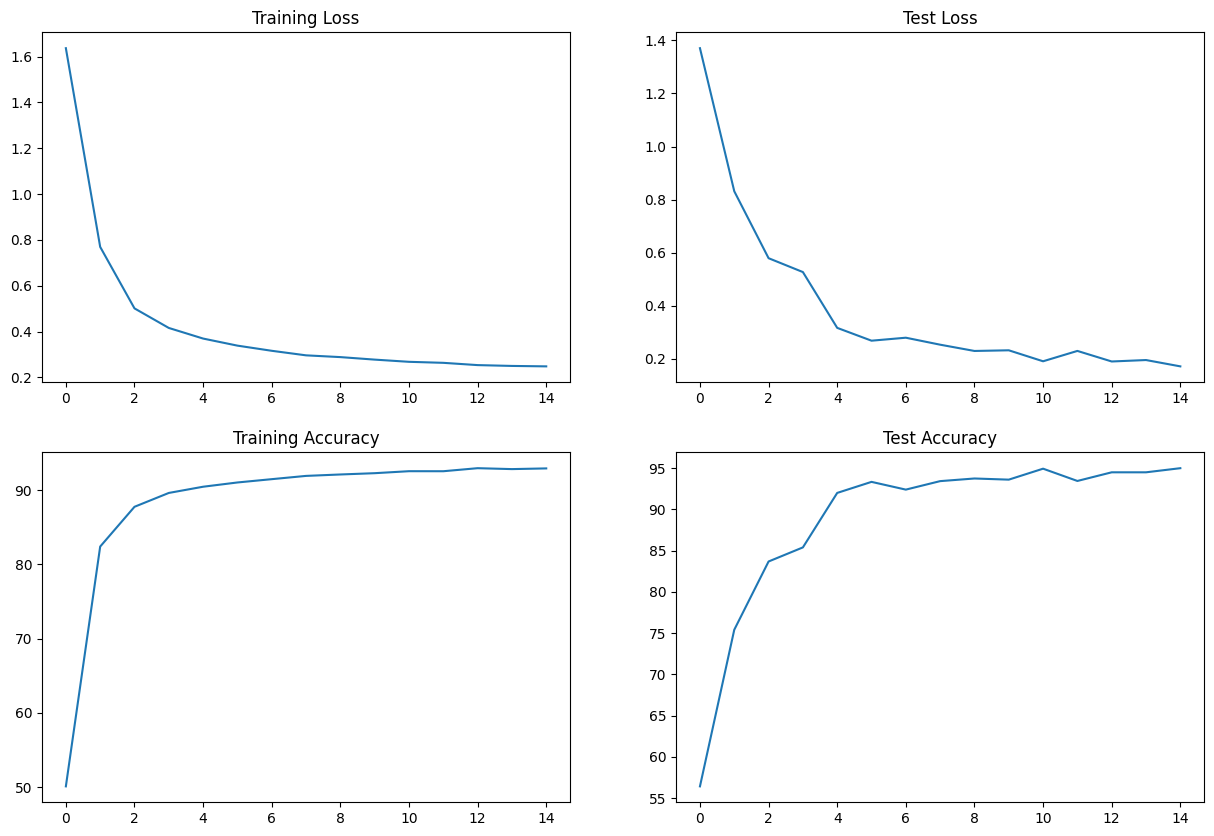

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")